In [1]:
pip install tensorflow numpy pandas matplotlib tqdm

In [2]:
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
dataset_zip_path = '/content/drive/MyDrive/Task 4/archive.zip'

# Function to load images and labels directly from zip file based on filename patterns
def load_gesture_data_from_zip(zip_path, img_size=(64, 64)):
    images = []
    labels = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.endswith('.jpg') or file_info.filename.endswith('.png'):
                label = file_info.filename.split('/')[-2]  # Assuming folder names are the labels
                with zip_ref.open(file_info.filename) as file:
                    img_array = np.frombuffer(file.read(), np.uint8)
                    img = cv2.imdecode(img_array, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
# Load gesture data
X, y = load_gesture_data_from_zip(dataset_zip_path)

# Encode labels to integers
label_to_int = {label: idx for idx, label in enumerate(np.unique(y))}
y_encoded = np.array([label_to_int[label] for label in y])

# Normalize images
X = X / 255.0

# Add a channel dimension for grayscale images
X = X[..., np.newaxis]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_to_int))
y_test = to_categorical(y_test, num_classes=len(label_to_int))

In [5]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_to_int), activation='softmax')
])

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Save the trained model
model.save('gesture_recognition_model.h5')
print("Model saved as 'gesture_recognition_model.h5'")

Epoch 1/10
800/800 [==============================] - 11s 7ms/step - loss: 0.2456 - accuracy: 0.9169 - val_loss: 0.0024 - val_accuracy: 0.9994
Epoch 2/10
800/800 [==============================] - 6s 7ms/step - loss: 0.0294 - accuracy: 0.9907 - val_loss: 5.5227e-04 - val_accuracy: 0.9998
Epoch 3/10
800/800 [==============================] - 5s 6ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 1.7084e-04 - val_accuracy: 1.0000
Epoch 4/10
800/800 [==============================] - 5s 6ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 1.3622e-05 - val_accuracy: 1.0000
Epoch 5/10
800/800 [==============================] - 5s 6ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 2.2073e-04 - val_accuracy: 0.9998
Epoch 6/10
800/800 [==============================] - 4s 6ms/step - loss: 0.0093 - accuracy: 0.9971 - val_loss: 0.0013 - val_accuracy: 0.9995
Epoch 7/10
800/800 [==============================] - 5s 6ms/step - loss: 0.0071 - accuracy: 0.9973 - val_loss: 7.3805e-04 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

250/250 [==============================] - 1s 4ms/step - loss: 1.7897e-05 - accuracy: 1.0000
Test accuracy: 1.0000


1/1 [==============================] - 0s 249ms/step


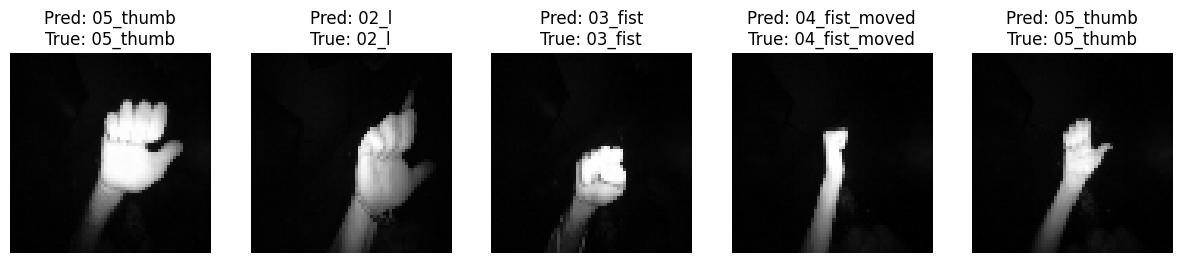

In [8]:
# Function to display some predictions
def display_predictions(model, X, y_true, label_int_mapping, num_images=5):
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = X[i].reshape(64, 64)
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f"Pred: {label_int_mapping[y_pred_classes[i]]}\nTrue: {label_int_mapping[y_true_classes[i]]}")
        ax.axis('off')
    plt.show()

# Display some predictions
int_to_label = {v: k for k, v in label_to_int.items()}
display_predictions(model, X_test[:5], y_test[:5], int_to_label)